In [1]:
# data_prep.py

import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from joblib import dump
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf

In [2]:
tf.__version__

'2.3.0'

In [3]:
data = Path.cwd().resolve().parents[0] / "data" 
df = pd.DataFrame()

In [4]:
FILES = list(data.glob("*.csv"))
print(f'total files found: {len(FILES)}')
for file in FILES:
    df_ = pd.read_csv(str(file), parse_dates=["Date"])
    df_['Date'] = pd.to_datetime(df_["Date"])
    df =  df.append(df_)
    df.sort_values(by="Date", inplace=True)
    df.drop_duplicates(inplace=True)

total files found: 5


In [5]:
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,2017-01-02,18242.30,18249.00,17844.90,17969.60,74444730,1857.24
1,2017-01-03,18002.75,18115.05,17830.95,18035.60,64513818,1769.30
2,2017-01-04,18037.45,18092.85,17868.90,17891.00,50508161,1615.85
3,2017-01-05,18000.75,18164.05,17977.80,18115.95,68874940,2271.18
4,2017-01-06,18168.45,18325.50,18157.30,18264.00,65919927,2174.59


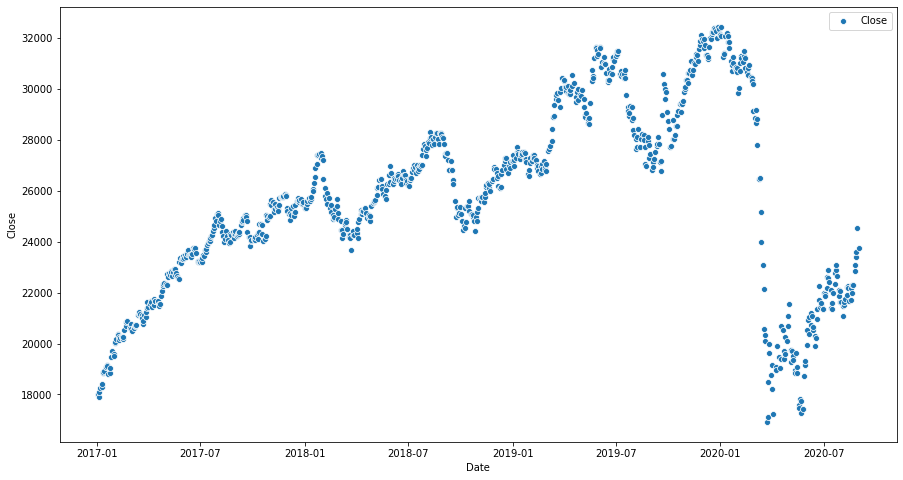

In [6]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x=df.Date, y=df.Close, label="Close", markers="o")
plt.legend()
plt.show()

In [7]:
df.shape

(906, 7)

In [8]:
df.sort_values(by="Date")

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,2017-01-02,18242.30,18249.00,17844.90,17969.60,74444730,1857.24
1,2017-01-03,18002.75,18115.05,17830.95,18035.60,64513818,1769.30
2,2017-01-04,18037.45,18092.85,17868.90,17891.00,50508161,1615.85
3,2017-01-05,18000.75,18164.05,17977.80,18115.95,68874940,2271.18
4,2017-01-06,18168.45,18325.50,18157.30,18264.00,65919927,2174.59
...,...,...,...,...,...,...,...
162,2020-08-25,22973.40,23180.30,22857.90,23092.15,422190044,10281.9
163,2020-08-26,23175.55,23453.40,23093.15,23414.20,337920632,9538.81
164,2020-08-27,23511.45,23704.05,23464.15,23600.35,430926732,11647.7
165,2020-08-28,23635.30,24611.80,23599.20,24523.80,812646625,19923.7


In [9]:
for lag in range(2):
    df["lag"+str(lag+1)] = df["Close"].shift(lag+1)

In [10]:
df.iloc[:, 7:].dropna(inplace=True)

In [11]:
df.dropna(inplace=True)

In [12]:
df.head(10)

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),lag1,lag2
2,2017-01-04,18037.45,18092.85,17868.90,17891.00,50508161,1615.85,18035.60,17969.60
3,2017-01-05,18000.75,18164.05,17977.80,18115.95,68874940,2271.18,17891.00,18035.60
4,2017-01-06,18168.45,18325.50,18157.30,18264.00,65919927,2174.59,18115.95,17891.00
5,2017-01-09,18314.25,18373.10,18256.15,18286.65,42677260,1404.38,18264.00,18115.95
6,2017-01-10,18351.45,18441.15,18275.75,18409.60,59993426,2012.18,18286.65,18264.00
7,2017-01-11,18535.35,18889.45,18515.25,18830.00,102842482,3493.47,18409.60,18286.65
8,2017-01-12,18885.45,18966.30,18805.85,18873.95,66286062,1982.54,18830.00,18409.60
9,2017-01-13,18949.70,18952.25,18781.25,18912.10,55762182,1855.30,18873.95,18830.00
10,2017-01-16,18899.70,19134.50,18865.25,19096.45,59319825,1740.77,18912.10,18873.95
11,2017-01-17,19128.15,19202.25,18981.85,19067.05,63686033,1862.62,19096.45,18912.10


In [13]:
df.Date.max(),  df.Date.min()

(Timestamp('2020-08-31 00:00:00'), Timestamp('2017-01-04 00:00:00'))

In [14]:
feat = df.iloc[:, 7:].values
mn = MinMaxScaler(feature_range=(0, 1))
features = mn.fit_transform(feat) 
target = df.Close.values

In [15]:
features.shape, target.shape

((904, 2), (904,))

In [38]:
train_len = int(features.shape[0] * 0.95)
train_feat = features[:train_len]
train_target = df.Close.values[:train_len]
val_feat = features[train_len:]
val_target = df.Close.values[train_len:]

In [39]:
train_feat.shape, train_target.shape, val_feat.shape, val_target.shape

((858, 2), (858,), (46, 2), (46,))

In [40]:
train_feat = train_feat.reshape((train_feat.shape[0], 1, train_feat.shape[1]))
train_target  = train_target.reshape((-1, 1))
val_feat = val_feat.reshape((val_feat.shape[0], 1, val_feat.shape[1]))
val_target = val_target.reshape((-1, 1))
train_feat.shape, train_target.shape, val_feat.shape, val_target.shape

((858, 1, 2), (858, 1), (46, 1, 2), (46, 1))

In [41]:
model = tf.keras.Sequential()
model.add(LSTM(50 , activation="relu", input_shape=(1,train_feat.shape[2]), return_sequences=True))
model.add(LSTM(50, activation="relu", return_sequences=True))
model.add(LSTM(50, activation="relu", return_sequences=True))
model.add(LSTM(50, activation="relu", return_sequences=True))
model.add(LSTM(50, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam" , loss="mae", metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 50)             10600     
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
lstm_20 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
lstm_21 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
lstm_22 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 91,451
Trainable params: 91,451
Non-trainable params: 0
__________________________________________________

In [42]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
history = model.fit(x=train_feat,
          y=train_target,
            batch_size=32,
         validation_data=(val_feat, val_target),
          epochs=100,
        callbacks=[cb]
         )

Epoch 1/100
27/27 [==============================] - 1s 31ms/step - loss: 25929.0586 - accuracy: 0.0000e+00 - val_loss: 22218.9863 - val_accuracy: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 25928.9766 - accuracy: 0.0000e+00 - val_loss: 22218.8594 - val_accuracy: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 25928.5898 - accuracy: 0.0000e+00 - val_loss: 22217.9844 - val_accuracy: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 25901.7676 - accuracy: 0.0000e+00 - val_loss: 22163.2871 - val_accuracy: 0.0000e+00
Epoch 5/100
27/27 [==============================] - 0s 7ms/step - loss: 25348.9902 - accuracy: 0.0000e+00 - val_loss: 21296.2383 - val_accuracy: 0.0000e+00
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 21375.9980 - accuracy: 0.0000e+00 - val_loss: 16215.5859 - val_accuracy: 0.0000e+00
Epoch 7/100
27/27 [==============================] - 0s 8

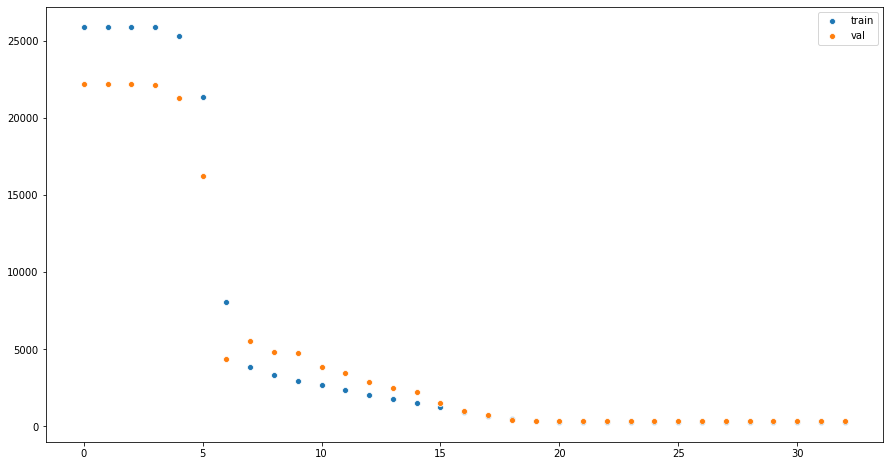

In [43]:
plt.figure(figsize=(15,8))
sns.scatterplot(y=history.history["loss"], x=range(len(history.history["loss"])), label="train")
sns.scatterplot(y=history.history["val_loss"], x=range(len(history.history["loss"])), label="val")
plt.legend()
plt.show()

In [44]:
model.save("model.h5")

In [45]:
predictions = model.predict(val_feat)

In [46]:
date = pd.date_range(end="2020-08-31", freq="D", periods=predictions.shape[0])

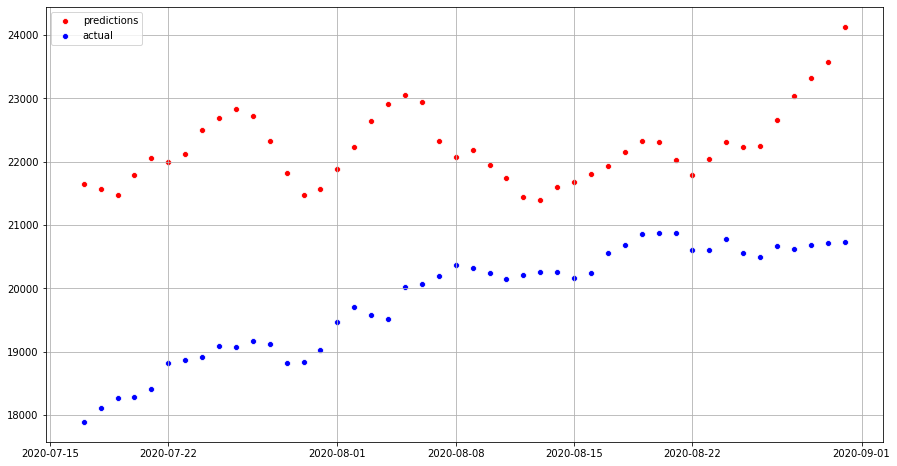

In [52]:
plt.figure(figsize=(15,8))
sns.scatterplot(y=predictions.reshape((-1)).tolist(), x=date , label="predictions", color="red")
sns.scatterplot(y=train_target.reshape((-1)).tolist()[:len(date)], x=date, label="actual", color="blue")
plt.legend()
plt.grid()
plt.show()
